In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Image
from exp_utils import Generator, Human_Annotator, wrap_unet1d, progressive_leap, make_plot

## Model Training
Run `FFHQ_train_flow.py`

## Util Functions

In [2]:
device = 'cuda'
# StyleGAN
truncation_psi=1.
noise_mode='const'
stylegan_weight_path = 'checkpoints/stylegan3-r-ffhq-1024x1024.pkl'
# Unet
unet_dim = 512
unet_weight_path = 'checkpoints/ffhq_unet1d_w_20000_final.pt'
# data
num_img = 8
# selection_random_seed = 2026
# selection_random_seed = 12345
selection_random_seed = 56789

In [3]:
generator = Generator(device = device, truncation_psi=truncation_psi, noise_mode=noise_mode, pkl_path = stylegan_weight_path)
annotator = Human_Annotator(device = device)
classifier = lambda z: annotator(generator.generate(z))

model = wrap_unet1d(
        dim = unet_dim,
        num_classes = 2,
).to(device)
model.load_state_dict(torch.load(unet_weight_path, weights_only=True))#,  map_location= {'cuda:5':device}))
model.eval()
print()

## Qualitative Evaluation

In [ ]:
init_data_list = []
torch.manual_seed(seed=selection_random_seed)
# Select non-smiling faces
while len(init_data_list) < num_img // 2:
    # randomly sample z
    z = torch.randn(1, 512, device=device)
    # convert to w-space
    init_data_cand = generator.G.mapping(z, c = None)[:, 0]
    source_y = annotator(generator.generate(init_data_cand))
    if (source_y[0] == 1):
        init_data_list.append(init_data_cand)
# Select Smiling faces
while len(init_data_list) < num_img:
    # randomly sample z
    z = torch.randn(1, 512, device=device)
    # convert to w-space
    init_data_cand = generator.G.mapping(z, c = None)[:, 0]
    source_y = annotator(generator.generate(init_data_cand))
    if (source_y[0] == 0):
        init_data_list.append(init_data_cand)
init_data = torch.cat(init_data_list, dim = 0)

### CE

In [ ]:
# LeapFactual
target_y = torch.hstack([torch.zeros(num_img // 2, dtype=torch.int64, device = device), torch.ones(num_img // 2, dtype=torch.int64, device = device)])
gamma_lift = gamma_land = .8
n_steps = 5
max_itr = 10
traj_list = progressive_leap(model, init_data, classifier, target_y, gamma_lift = gamma_lift, gamma_land = gamma_land, n_steps = n_steps, max_itr = max_itr)

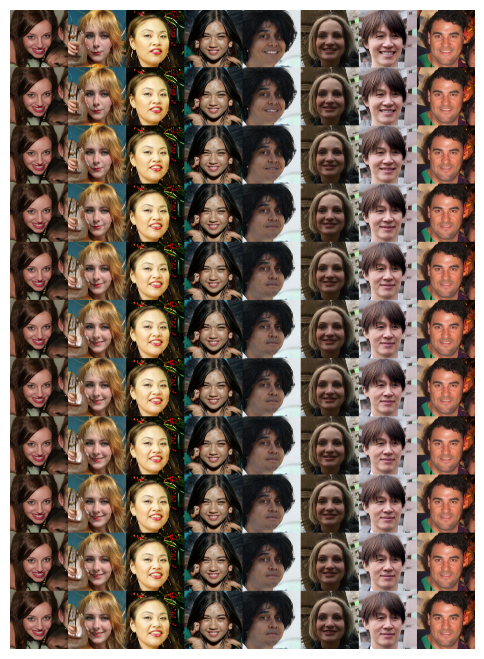

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (6, 12))
make_plot([init_data] + traj_list, generator, num_img, ax)

### Robust CE

In [7]:
# LeapFactual
target_y = torch.hstack([torch.zeros(num_img // 2, dtype=torch.int64, device = device), torch.ones(num_img // 2, dtype=torch.int64, device = device)])
gamma_lift = 0.8
gamma_land = 0.83
n_steps = 5
max_itr = 5
init_data_robust = traj_list[-1]
traj_list_robust = progressive_leap(model, init_data_robust, classifier, target_y, gamma_lift = gamma_lift, gamma_land = gamma_land, n_steps = n_steps, max_itr = max_itr)

Processing itration 0, predicted label [0 0 0 0 1 0 1 1]
Processing itration 1, predicted label [0 1 0 0 0 1 1 0]
Processing itration 2, predicted label [0 0 0 0 1 1 1 1]
Processing itration 3, predicted label [0 0 1 0 0 1 0 1]
Processing itration 4, predicted label [0 0 0 0 0 1 1 1]
Finish, predicted label [0 0 0 0 1 1 1 1]


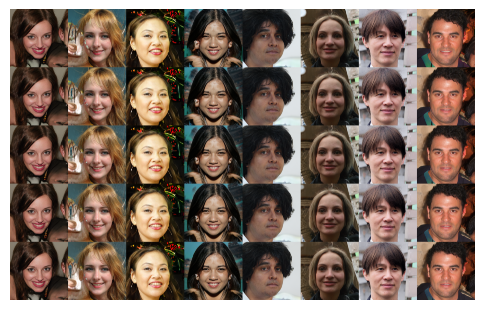

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
make_plot(traj_list_robust, generator, num_img, ax)

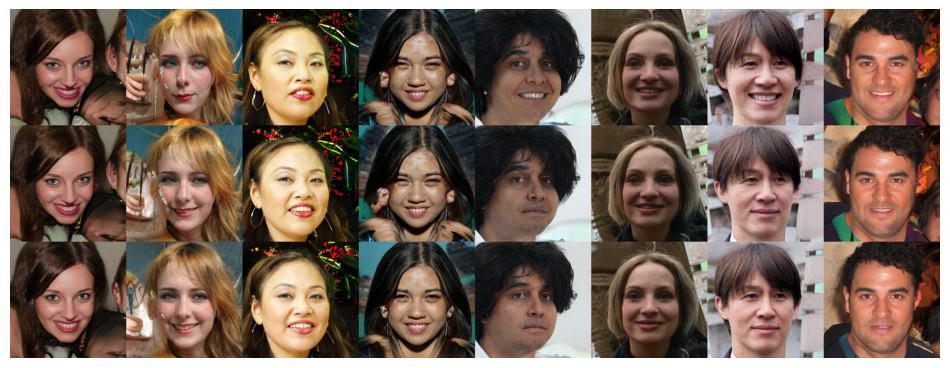

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
make_plot([init_data, traj_list[-1], traj_list_robust[4]], generator, num_img, ax)

In [10]:
# fig.savefig('FFHQ_compare.svg', dpi = 300, bbox_inches='tight')

## Quantitative evaluation
Check `FFHQ_quantitative_eval.py`